In [1]:
# Just taking the 2 --> 1 transition
# Or up_level = 2; low_level = 1
# i.e., i = 1; j = 0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [311]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '%f kpc' %(r_e*1.4))
region = data[sph_5]
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])
turb = np.sqrt( region.g["turb"] * 2./3. ) * unit_l / unit_t / 1e5
# turb = pynbody.array.SimArray(turb*1e5, "cm s**-1")

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [314]:
turb = pynbody.array.SimArray(turb, "km s**-1")
turb

SimArray([29.15456777, 44.73850117, 68.11498304, ..., 29.26368001,
          16.37539853, 25.15026196], 'km s**-1')

In [3]:
n_H_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H.npy'), "cm**-3")
n_H2_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H2.npy'), "cm**-3")
X_H2_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/X_H2.npy'), "1")
n_LW_arr = np.load('outputs/sub_grid/n_LW.npy')
n_LW_ss_arr = np.load('outputs/sub_grid/n_LW_ss.npy')
X_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/X_H2_ss.npy'), "1")
n_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H2_ss.npy'), "cm**-3")
X_CO_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/X_CO.npy'), "1")
n_CO_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_CO.npy'), "cm**-3")
pdf_arr = np.load('outputs/sub_grid/pdf.npy')
lambda_jeans_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/lambda_jeans.npy'), "cm")

In [4]:
#Defining all the constants used in this whole program

m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
mach_no = pynbody.array.SimArray(10., "1")
metallicity = 0.02/0.02
G_o = 1
n_H_mean = pynbody.array.SimArray(100., "cm**-3")
# c_si = pynbody.array.SimArray(299792458, "m s**-1")
c_cgs = pynbody.array.SimArray(2.99792458e10, "cm s**-1")
h_ev = pynbody.array.SimArray(4.13566770e-15, "eV s")
# h_si = pynbody.array.SimArray(6.626e-34, "J s")
mH_cgs = pynbody.array.SimArray(1.6737236e-24, 'g')  # hydrogen mass
T_bg = pynbody.array.SimArray(2.73, "K")
eV = pynbody.array.SimArray(6.241509e18, "J")

#pynbody.array.SimArray(, "")

In [5]:
def get_filename(species):
    # filename is already given
    if (species[-4:] == '.dat') or (species[-4:] == '.txt'):
        return species
    # molecule is chosen
    THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
    database = os.path.join(THIS_FOLDER, 'LAMDA')
    if species == 'HCO+':
        filename = os.path.join(database, 'HCO+.dat')
    elif species == 'H13CO+':
        filename = os.path.join(database, 'H13CO+.dat')
    elif species == 'N2H+':
        filename = os.path.join(database, 'N2H+.dat')
    elif species == 'SiO':
        filename = os.path.join(database, 'SiO.dat')
    elif species == 'HNC':
        filename = os.path.join(database, 'HNC.dat')
    elif species == 'HCN':
        filename = os.path.join(database, 'HCN.dat')
    elif species == 'CO':
        filename = os.path.join(database, 'CO.dat')
    else:
        print('Unknow species. Chose from HCO+, H13CO+, N2H+, SiO, HNC, HCN, CO')
        print('or provide a LAMDA datafile.')
        exit()

    return filename

def read_file(species):
    filename = get_filename(species)
    f = open(filename, 'r')

    f.readline()
    species = f.readline()

    f.readline()
    mu = float(f.readline())  # molecular weight

    f.readline()
    num_lvls = int(f.readline())  # number of energy levels

    # read energy levels: energy E, statistical weight g
    f.readline()
    E = []
    g = []
    for l in range(num_lvls):
        words = f.readline().split()
        E.append(float(words[1]) *c_cgs*h_ev) # cm^-1 -> eV
        g.append(float(words[2]))

    f.readline()
    num_trans = int(f.readline())  # number of radiative transistions

    # read transistions: upper lvl, lower lvl, A-coefficient, frequency
    f.readline()
    A = np.zeros((num_lvls, num_lvls))
    freq = np.zeros((num_lvls, num_lvls))
    for t in range(num_trans):
        words = f.readline().split()
        up = int(words[1]) - 1
        low = int(words[2]) - 1
        if up-low==1:
            A[up][low] = float(words[3])  # s^-1
            freq[up][low] = float(words[4]) * 1e9  # GHz -> Hz
            #freq[low][up] = freq[up][low] #un-comment this only if low->up transitions are also allowed

    # compute B-coefficient via Einstein relations
    # Bij = coeff for stimulated emission, Bji = coeff for extinction (j<i)
    B = np.zeros((num_lvls, num_lvls))
    for i in range(0, num_lvls):
        for j in range(0, i):
            if A[i][j] != 0:
                B[i][j] = A[i][j] * (c_cgs**2) / (2*h_ev * (freq[i][j])**3) # cm2/(eV*s)
                B[j][i] = B[i][j] * g[i]/g[j]

    # number of collision partners in the data file
    f.readline()
    num_partners = int(f.readline())

    C_all = []
    temps_all = []
    for partner in range(num_partners):
        # reference
        f.readline()
        line = f.readline()

        # number of collisional transitions
        f.readline()
        num_coll = int(f.readline())

        # number of temperatures in the table
        f.readline()
        num_temps = int(f.readline())

        # read the temperature values
        f.readline()
        words = f.readline().split()
        temps = np.zeros(num_temps)
        for t in range(num_temps):
            temps[t] = float(words[t])
            temps_all.append(temps)  # K

        # read collision coeff data: upper lvl, lower lvl, C-coefficient for each temp
        C = np.zeros((num_temps, num_lvls, num_lvls))
        f.readline()
        for col in range(num_coll):
            words = f.readline().split()
            i = int(words[1]) - 1
            j = int(words[2]) - 1
            for t in range(num_temps):
                C[t][i][j] = float(words[3+t]) #* 1.e-6 # cm3/s -> m3/s

        # calculate the inverse coefficient via LTE relation
        for i in range(num_lvls):
            for j in range(i):
                for t in range(num_temps):
                    if C[t][i][j] != 0:
                        C[t][j][i] = C[t][i][j] * np.exp(-(E[i]-E[j])/(K_b_ev*temps[t]))*g[i]/g[j]

        # add collision partner data to global array
        C_all.append(C)

    f.close()
    C_all = np.array(C_all) #cm3/s
    temps_all = np.array(temps_all) #K
    E = np.array(E) #eV
    g = np.array(g) 
    freq = np.array(freq) #Hz
    A = np.array(A) #s-1
    B = np.array(B) #cm2/(eV*s)
    return mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, num_coll

''' Load preset abundances and fraction for collision coefficients
    PARAMS:
      species = string with the particle name
    RETURNS:
      comp_fracs = list with the fraction of total collision partner density for each partner
      abundance = overall abundance of the molecule (assume n_mol = abundance*rho everywhere)'''
def load_species_info(species):

    if species == 'HCO+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 1.e-09 # = N_species/N_h2
    elif species == 'H13CO+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 2.e-11
    elif species == 'N2H+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 1.e-10
    elif species == 'SiO': # is seems to be unusually slow
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 7.7e-12
    elif species == 'HNC':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 3.1e-10
    elif species == 'HCN':
        comp_fracs = [1.0, 0.0] # H2 and e
        abundance = 3.1e-11
    elif species == 'CO':
        comp_fracs = [0.66, 0.33] # para H2 and orhto H2
        #abundance = 1.e-4
        abundance = 1.0 # dummy for filenames
    else:
        print 'ERROR: Unsupported species'
        exit()

    return comp_fracs, abundance

''' Calculate net collision coeff for a gas consisting of different components at temp T
    Interpolates table betweem T values
    PARAMS:
      T = temperature (K)
      comp_fractions = fraction of the total density in each component
    RETRUN:
      C = netto collision coeff C[i][j] (m3/s) '''
def calc_total_C(T, comp_fractions):
    C = np.zeros((num_lvls,num_lvls))
    for p in range(num_partners):
        max_index = len(temps_all[p])
        if T <= temps_all[p][0]: # T is lower than lowest value in table
            for i in range(num_lvls):
                for j in range(num_lvls):
                    C[i][j] = C[i][j] + comp_fractions[p] * C_all[p][0][i][j]
        elif T >= temps_all[p][max_index-1]: # T is higher than highest value in table
            for i in range(num_lvls):
                for j in range(num_lvls):
                    C[i][j] = C[i][j] + comp_fractions[p] * C_all[p][max_index-1][i][j]
        else: # determine temperature entries needed to interpolate
            t = 1 # T index of upper limit
            while temps_all[p][t] < T:
                t = t+1
            t_frac = (temps_all[p][t] - T)/(temps_all[p][t] - temps_all[p][t-1])
            for i in range(num_lvls):
                for j in range(num_lvls):
                    interpol = (1-t_frac) * C_all[p][t][i][j] + t_frac * C_all[p][t-1][i][j]
                    C[i][j] = C[i][j] + comp_fractions[p] * interpol

    return C

In [6]:
mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, n_coll = read_file('CO.txt')

In [50]:
# pynbody.array.SimArray(, "")
freq = pynbody.array.SimArray(freq, "Hz")
E = pynbody.array.SimArray(E, "eV")
A = pynbody.array.SimArray(A, "s**-1")
B = pynbody.array.SimArray(B, "cm**2 eV**-1 s**-1")
C = pynbody.array.SimArray(C, "cm**3 s**-1")
temps_all = pynbody.array.SimArray(temps_all, "K")

In [53]:
comp_fractions, abundance = load_species_info('CO')

In [54]:
# calc netto collision coeffs
C = calc_total_C(T_mean, comp_fractions)

In [55]:
def partion_function(T, num_lvls, g, E):
    Z=0.0
    for i in range(0,num_lvls):
        Z = Z + g[i]*np.exp(-E[i]/(K_b_ev*T))
    return np.array(Z)

def calc_lvlpops_partion(T, num_lvls, g, E):
    ni = np.zeros(num_lvls)
    Z = partion_function(T, num_lvls, g, E)
    for i in range(0, num_lvls):
        ni[i] = g[i]*np.exp(-E[i]/(K_b_ev*T)) / Z
    return np.array(ni), Z

In [56]:
ni, Z = calc_lvlpops_partion(T_mean, num_lvls, g, E)
ni = pynbody.array.SimArray(ni, "1")

In [62]:
c_s = np.sqrt(K_b * T_mean/(mH_cgs*mu))
c_s

SimArray(5427.76055106, 'cm s**-1')

In [352]:
def tau_LVG(N, nu_ij, lambda_jeans, n_i, n_j, B_ij, B_ji, c_s):
    # units: eV*s * Hz * cm * 1/cm3 * cm2/(eV*s) * 1/(Hz) = none
    delta_nu = c_s*nu_ij/c_cgs #"Hz"
    tau_lvg = h_ev*nu_ij*lambda_jeans*N*((n_j*B_ji)-(n_i*B_ij)) / (4*np.pi*delta_nu)
    return tau_lvg

def calc_line_profile(nu_ij):
    delta_nu = c_s*nu_ij/c_cgs #"Hz"
    line_profile = 1/delta_nu #Hz-1
    return line_profile
    
def beta_LVG(tau):
    if tau < 0.01:
        return 1. - tau/2.
    elif tau > 100.:
        return 1./tau
    else:
        return (1.0 - np.exp(-tau)) / tau

def B_nu_ev(nu, T):
    if nu==0.:
        return 0.
    if nu>0:
        x = h_ev*nu/(K_b_ev*T) #units: none
        #units: eV*s * Hz3 / (cm2/s2) = eV * s3 * Hz3 * cm-2 = eV/s/Hz/cm2
        B_nu_ev = 2.0*h_ev*(nu**3) / ((c_cgs**2) * (np.exp(x)-1.0))
        return B_nu_ev

def calc_emissivity(N, nu_ij, n_i, A_ij, phi_ij):
    #units: eV*s * Hz * cm-3 * s-1 * Hz-1 = eV/cm3
    j_nu = h_ev * nu_ij * N * n_i * A_ij * phi_ij / (4*np.pi)
    return j_nu

def calc_j_nu_bar(ds, beta_j_nu):
    j_nu_bar = 0.0
    for i in range(0, 100):
        j_nu_bar += beta_j_nu[i] * ds * pdf_arr[i]
    return j_nu_bar

def calc_temp_for_rad_field(nu, I_nu):
    foo = pynbody.array.SimArray(((2*h_ev*(nu**3))/((c_cgs**2)*I_nu)) + 1, "Hz**3 s**3") 
                                 #units: eV*s * Hz3 * cm-2*s2 * eV-1*cm2 = Hz3 * s3
    temp_for_rad_field = h_ev * nu / (np.log(foo) * K_b_ev) #units: eV*s * Hz * eV-1*K = Hz * s * K
    return temp_for_rad_field

In [353]:
tau_nu = np.zeros((len(n_CO_arr)))
beta_nu = np.zeros((len(n_CO_arr)))
B_nu = np.zeros((len(n_CO_arr)))
phi_nu = 0
j_nu = np.zeros((len(n_CO_arr)))
beta_j_nu = np.zeros((len(n_CO_arr)))
I_nu = np.zeros((len(n_CO_arr)))
j_nu_bar = 0.0
temp_nu = 0.0

sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = ((smax - smin)/100)
u = 1 #upper level
l = 0 #lower level
nu = freq[u][l]
n_i = ni[u]
n_j = ni[l]
A_ij = pynbody.array.SimArray(A[u][l], "s**-1")
B_ij = pynbody.array.SimArray(B[u][l], "cm**2 eV**-1 s**-1")
B_ji = pynbody.array.SimArray(B[l][u], "cm**2 eV**-1 s**-1")
B_nu = pynbody.array.SimArray(B_nu_ev(nu, T_mean), "eV cm**-2 s**-1 Hz**-1")
phi_nu = pynbody.array.SimArray(calc_line_profile(nu), "Hz**-1")
for ctr in range(0, 100):
    n_H = n_H_arr[ctr]
    n_CO = n_CO_arr[ctr]
    lambda_jeans = pynbody.array.SimArray(lambda_jeans_arr[ctr], "cm")
    N = pynbody.array.SimArray(n_CO, "cm**-3")
    Ni = pynbody.array.SimArray(ni*N, "cm**-3")
    tau_nu[ctr] = tau_LVG(N, nu, lambda_jeans, n_i, n_j, B_ij, B_ji, c_s)
    beta_nu[ctr] = beta_LVG(tau_nu[ctr])
    j_nu[ctr] = calc_emissivity(N, nu, n_i, A_ij, phi_nu)
beta_j_nu = pynbody.array.SimArray(beta_nu*j_nu, "eV cm**-3") #what comes out of the cell
j_nu_bar = pynbody.array.SimArray(calc_j_nu_bar(ds, beta_j_nu),  "eV cm**-3 s**-1 Hz**-1")


# temp_nu = pynbody.array.SimArray(calc_temp_for_rad_field(nu, I_nu), "K")

In [354]:
tau_nu = pynbody.array.SimArray(tau_nu, "1")
beta_nu = pynbody.array.SimArray(beta_nu, "1")
j_nu = pynbody.array.SimArray(j_nu, "eV cm**-3")

In [355]:
j_nu_bar

SimArray(1.18570433e-22, 'eV cm**-3 s**-1 Hz**-1')

In [356]:
np.sum(beta_j_nu*ds*pdf_arr)

SimArray(1.18570433e-22, 'eV cm**-3')

In [345]:
temp_nu

SimArray(0.11968412, 'K')

In [315]:
turb

SimArray([29.15456777, 44.73850117, 68.11498304, ..., 29.26368001,
          16.37539853, 25.15026196], 'km s**-1')

In [316]:
np.shape(turb)

(1291634,)

In [317]:
r_e

SimArray(15.24043261, 'kpc')

In [321]:
width_of_cell = pynbody.array.SimArray(r_e*1e3/np.shape(turb), "pc")

In [323]:
surface_area = 6*(width_of_cell**2)
surface_area

SimArray([0.00083535], 'pc**2')

In [329]:
rho = region.gas["rho"].in_units("m_p km**-3")
rho

SimArray([2.42817576e+12, 1.63667538e+11, 3.89477443e+11, ...,
          3.22726555e+11, 2.36468977e+11, 2.92905853e+11], 'm_p km**-3')

In [336]:
sigma_turb = turb[0]

In [339]:
luminosity = I_nu * surface_area * sigma_turb
luminosity

SimArray([2.88768567e-24], 'pc**2 eV s**-1 Hz**-1 cm**-2')

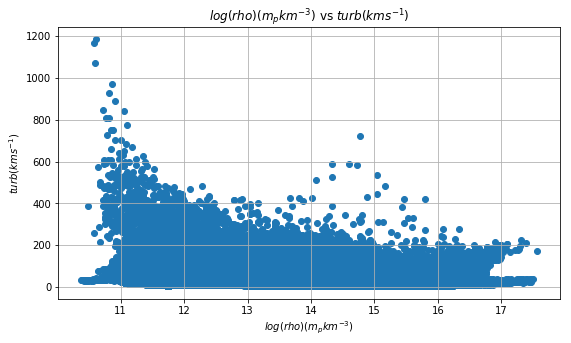

In [335]:
fig = plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(rho), turb)
# ax.set_ylim([1e-43,2e-6])
# ax.set_ylim([0,1.25e-22])
plt.xlabel('$log(rho)  (m_p km^{-3})$')
plt.ylabel('$turb  (km s^{-1})$')
plt.grid(b=True, which='both', axis='both')
plt.title('$log(rho) (m_p km^{-3})$ vs $turb (km s^{-1})$')
# plt.legend()
plt.show()

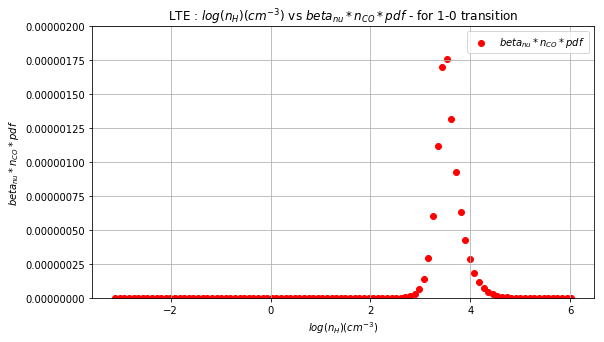

In [332]:
fig = plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr), beta_nu*n_CO_arr*pdf_arr, c='r',
            label='$beta_{nu} * n_{CO} * pdf$')
#plt.scatter(np.log10(n_H_arr), X_CO_arr)
#ax.set_xlim([xmin,xmax])
ax.set_ylim([1e-43,2e-6])
#ax.set_ylim([0,1.25e-22])
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$beta_{nu} * n_{CO} * pdf$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $beta_{nu} * n_{CO} * pdf$ - for 1-0 transition')
plt.legend()
plt.savefig('radiative_transfer/outputs_RT/1.2/LTE_log(n_H)vsbeta_n_CO_pdf.png', 
            dpi=300, bbox_inches='tight')
plt.show()

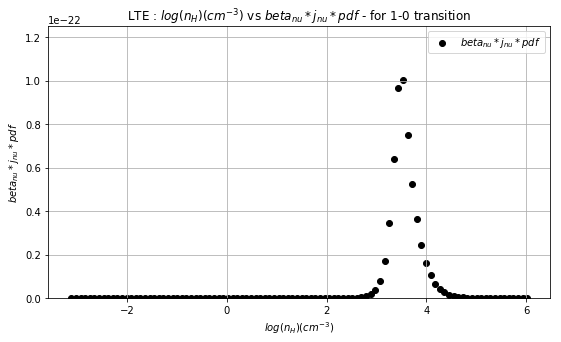

In [285]:
fig = plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr), beta_j_nu*pdf_arr, c='k',
            label='$beta_{nu}* j_{nu} * pdf$')
#plt.scatter(np.log10(n_H_arr), X_CO_arr)
#ax.set_xlim([xmin,xmax])
ax.set_ylim([0,1.25e-22])
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$beta_{nu} * j_{nu} * pdf$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $beta_{nu} * j_{nu} * pdf$ - for 1-0 transition')
plt.legend()
plt.savefig('radiative_transfer/outputs_RT/1.2/LTE_log(n_H)vsbeta_j_nu_pdf.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [261]:
np.max(beta_j_nu*pdf_arr)

SimArray(1.00304884e-22, 'eV cm**-3')

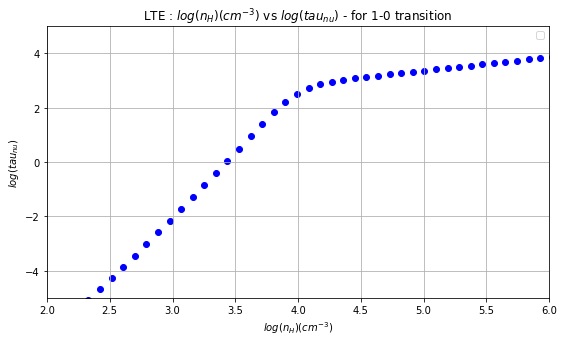

In [298]:
fig = plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr), np.log10(tau_nu), c='b')
ax.set_xlim([2,6])
ax.set_ylim([-5,5])
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$log(tau_{nu})$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $log(tau_{nu})$ - for 1-0 transition')
plt.legend()
plt.savefig('radiative_transfer/outputs_RT/1.2/LTE_log(n_H)vslog(tau).png', 
            dpi=300, bbox_inches='tight')
plt.show()

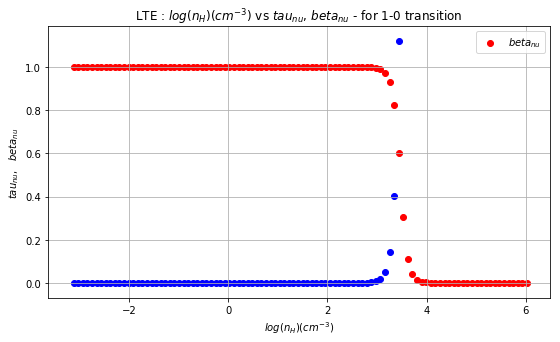

In [299]:
plt.figure(figsize=(9,5))
plt.scatter(np.log10(n_H_arr), beta_nu, c='r',
            label='$beta_{nu}$')
for i in range(0, 100):
    if (tau_nu[i]<2):
        plt.scatter(np.log10(n_H_arr[i]), tau_nu[i], c='b')
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$tau_{nu}$,   $beta_{nu}$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $tau_{nu}$, $beta_{nu}$ - for 1-0 transition')
plt.legend()
# plt.savefig('radiative_transfer/outputs_RT/1.2/LTE_log(n_CO)_vs_tau_vs_beta.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

In [310]:
print "i  n_H                    tau                     beta     j_nu                   lambda_jeans"
for k in range(0,100):
    print k,"",n_CO_arr[k],"",tau_nu[k]," ",beta_nu[k],"  ",j_nu[k]," ",lambda_jeans_arr[k]

i  n_H                    tau                     beta     j_nu                   lambda_jeans
0  5.208016862739764e-32  1.3580178434911794e-25   1.0    2.96487384042777e-48   8.738310414741158e+20
1  1.2186600714096998e-31  2.8574915879019086e-25   1.0    6.937714414764179e-48   7.857723673534708e+20
2  2.8517484359043585e-31  6.012884678455654e-25   1.0    1.623472918758122e-47   7.065876399340143e+20
3  6.673602523267372e-31  1.2653226528765783e-24   1.0    3.799217641595583e-47   6.353826039837457e+20
4  1.5618245754872415e-30  2.662824123315979e-24   1.0    8.891316885566532e-47   5.713531211540386e+20
5  3.6553545863376686e-30  5.60414064876799e-24   1.0    2.080958160496219e-46   5.137760886207909e+20
6  8.555688321794962e-30  1.1795157749206414e-23   1.0    4.8706709599244215e-46   4.6200127288236605e+20
7  2.002680822804955e-29  2.482731883538331e-23   1.0    1.1401069041733383e-45   4.154439664911436e+20
8  4.6881702523835325e-29  5.226256746740676e-23   1.0    2.668930171906